<a href="https://colab.research.google.com/github/MosaicGroupCMU/African-MRS-Tutorials/blob/main/Google-Colab/Answers/7_QE_Vibration_in_Solids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vibrational modes of extended systems

In [ ]:
! apt install quantum-espresso
! pip install ase
! cd /content/  
! gdown 'https://drive.google.com/uc?export=download&id=13l-Kiyg-F6aYb5lF8M3RsE1hSnLRdGna' -O qe-lite.tgz
! tar -xvzf qe-lite.tgz
! rm -rf sample_data qe-lite.tgz

In [53]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from ase.io import read
from ase.calculators.espresso import EspressoProfile, Espresso

pseudo_dir = Path('/content/qe-lite/pseudopotentials/')
qepath     = Path('')
pwx        = Path(qepath, 'pw.x')
phx        = Path(qepath, 'ph.x')
dynmatx    = Path(qepath, 'dynmat.x')
matdynx    = Path(qepath, 'matdyn.x')
q2rx       = Path(qepath, 'q2r.x')
plotbandx  = Path(qepath, 'plotband.x')

profile = EspressoProfile(
    command=f'{pwx} -in PREFIX.pwi > PREFIX.pwo', 
    pseudo_dir=pseudo_dir,
)

## Silicon: vibration in solids (phonons)

### Step 1: define the structure

In [31]:
from ase.build import bulk

si = bulk('Si')

### Step 2: relax atomic positions and lattice vectors

In [32]:
calc = Espresso(
    profile=profile,
    pseudopotentials={
        'Si': 'Si.UPF',
    },
    input_data={
        'control': {
            'calculation': 'vc-relax',
            'forc_conv_thr': 1.0e-3,
            'verbosity': 'high',
            'tstress': True,
            'tprnfor': True,
        },
        'system': {
            'ecutwfc': 30,
            'ecutrho': 240,
            'occupations': 'fixed',
        },
        'electrons': {
            'conv_thr': 1.0e-8,
        },
    },
    kpts=(2, 2, 2)
)

# Attach the calculator to the H2O molecule
si.calc = calc

si.get_potential_energy()
si_relaxed = read('espresso.pwo')

! cat espresso.pwo

### Step 3: calculate phonons

In [33]:
ph_inputs = """
&INPUTPH
  tr2_ph=1.0e-12,
  prefix='pwscf',
  verbosity='high',
  epsil=.true.
  alpha_mix(1)=0.4
  ldisp=.true
  nq1=2
  nq2=2
  nq3=2
/
"""

with open('ph_si.in', 'w+') as handle:
    handle.write(ph_inputs)

import subprocess

command = [str(phx), "-nk", "1", "-in", "ph_si.in"]

with open("ph_si.out", "w") as outfile:
  subprocess.run(command, stdout=outfile, stderr=subprocess.STDOUT)

! cat ph_si.out

### Step 4: diagonalize dynamical matrix

In [34]:
dynmat_inputs = """
&INPUT
  fildyn='matdyn',
  asr='simple',
  filout='dynmat_si.out'
/
"""

with open('dynmat_si.in', 'w+') as handle:
    handle.write(dynmat_inputs)

import subprocess

command = [str(dynmatx), "-in", "dynmat_si.in"]

with open("dynmat_si.out", "w") as outfile:
  subprocess.run(command, stdout=outfile, stderr=subprocess.STDOUT)

! cat dynmat_si.out

### Step 5: calculate the force constants matrix

We can go from Fourier space (dynamical matrix) to real space (force constants matrix).

In [42]:
q2r_inputs = """
&INPUT
  fildyn='matdyn'
  flfrc='si.fc'
/
"""

with open('q2r_si.in', 'w+') as handle:
    handle.write(q2r_inputs)

import subprocess

command = [str(q2rx), "-in", "q2r_si.in"]

with open("q2r_si.out", "w") as outfile:
  subprocess.run(command, stdout=outfile, stderr=subprocess.STDOUT)

! cat q2r_si.out

### Step 6: interpolate the force constants

Having the force constants matrix, we can now interpolate it to plot the phonon dispersion.

In [80]:
print(si.cell.get_bravais_lattice().description())

FCC(a=5.43)
  Variant name: FCC
  Special point names: GKLUWX
  Default path: GXWKGLUWLK,UX

  Special point coordinates:
    G   0.0000  0.0000  0.0000
    K   0.3750  0.3750  0.7500
    L   0.5000  0.5000  0.5000
    U   0.6250  0.2500  0.6250
    W   0.5000  0.2500  0.7500
    X   0.5000  0.0000  0.5000



In [156]:
matdyn_inputs = """
&INPUT
    asr='crystal',
    flfrc='si.fc',
    flfrq='si.freq',
    q_in_band_form=.true.,
    q_in_cryst_coord=.true.,
/
6
    0.0000  0.0000  0.0000  100  ! Γ
    0.5000  0.0000  0.5000  100  ! X
    0.5000  0.2500  0.7500  100  ! W
    0.5000  0.0000  0.5000  100  ! X
    0.0000  0.0000  0.0000  100  ! Γ
    0.5000  0.5000  0.5000  100  ! L
"""

with open('matdyn_si.in', 'w+') as handle:
    handle.write(matdyn_inputs)

import subprocess

command = [str(matdynx), "-in", "matdyn_si.in"]

with open("matdyn_si.out", "w") as outfile:
  subprocess.run(command, stdout=outfile, stderr=subprocess.STDOUT)

! cat matdyn_si.out

Write files in plottable format.

In [161]:
plot_inputs = """
si.freq
-10 1000
bands.dat
bands.ps
0
10 10
"""

with open('plot_si.in', 'w+') as handle:
    handle.write(plot_inputs)

command = [str(plotbandx)]

with open("plot_si.in", "r") as infile, open("plot_si.out", "w") as outfile:
    subprocess.run(command, stdin=infile, stdout=outfile, stderr=subprocess.STDOUT)

! cat plot_si.out

Read the data and plot the phonon dispersion.

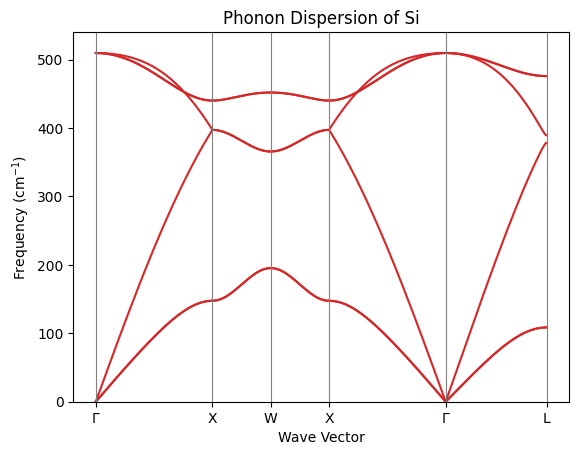

In [183]:
import numpy as np
import matplotlib.pyplot as plt

with open('bands.dat', 'r') as f:
    content = f.read()

blocks = content.strip().split('\n\n')

for block in blocks:
    data = np.loadtxt(block.strip().split('\n'))
    x = data[:, 0]
    y = data[:, 1]
    plt.plot(x, y, lw=1.5, c='C3')

high_symmetry_points = [0.0000,0.7006,1.0509,1.4012,2.1018,2.7085]

plt.ylim([0,540])
plt.vlines(high_symmetry_points, *plt.ylim(), colors='gray', linestyles='-', linewidth=.8)
plt.xticks(
    high_symmetry_points, # you can find in the file `plot_si.out`
    ['$\Gamma$', 'X', 'W', 'X', '$\Gamma$', 'L']
) 
plt.xlabel('Wave Vector')
plt.ylabel('Frequency ($\mathrm{cm}^{-1}$)')
plt.title('Phonon Dispersion of Si')
plt.show()

# AlAs: phonon dispersion of semiconductors

Vibrational modes in semiconductors are affected by long-range interactions when the displacement pattern happens in a large supercell. The effect of these interactions are more and more pronounced close to the $\Gamma$ point (i.e., modes in very large supercells). Due to this effect, vibrational frequencies of such polar _optical_ phonons are no more degenerate, and undergoe to what is called _LO-TO splitting_ (LO = longitudinal optical; TO = transversal optical).

In [196]:
from ase.atoms import Atoms

a = 2.875
cell = [
    [a,a,0],
    [a,0,a],
    [0,a,a],
]
gaas = Atoms(
    symbols=['Al','As'],
    scaled_positions=[[0,0,0],[1/4,1/4,1/4]],
    cell=cell,
    pbc=True,
)

In [197]:
calc = Espresso(
    profile=profile,
    pseudopotentials={
        'Al': 'Al.UPF',
        'As': 'As.UPF',
    },
    input_data={
        'control': {
            'calculation': 'vc-relax',
            'forc_conv_thr': 1.0e-3,
            'verbosity': 'high',
            'tstress': True,
            'tprnfor': True,
        },
        'system': {
            'ecutwfc': 30,
            'ecutrho': 240,
            'occupations': 'fixed',
        },
        'electrons': {
            'conv_thr': 1.0e-8,
        },
    },
    kpts=(2, 2, 2)
)

# Attach the calculator to the H2O molecule
gaas.calc = calc

gaas.get_potential_energy()
gaas_relaxed = read('espresso.pwo')

In [263]:
# Run PH
ph_inputs = """
&INPUTPH
  tr2_ph=1.0e-12,
  prefix='pwscf',
  verbosity='high',
  epsil=.false.
  zeu=.false.
  zue=.false.
  alpha_mix(1)=0.4
  trans=.true.
  ldisp=.true.
  nq1=2
  nq2=2
  nq3=2
/
"""

with open('ph_alas.in', 'w+') as handle:
    handle.write(ph_inputs)

command = [str(phx), "-nk", "1", "-in", "ph_alas.in"]

with open("ph_alas.out", "w") as outfile:
  subprocess.run(command, stdout=outfile, stderr=subprocess.STDOUT)

In [327]:
# Run Q2R
q2r_inputs = """
&INPUT
  fildyn='matdyn'
  flfrc='alas.fc'
/
"""

with open('q2r_alas.in', 'w+') as handle:
    handle.write(q2r_inputs)

import subprocess

command = [str(q2rx), "-in", "q2r_alas.in"]

with open("q2r_alas.out", "w") as outfile:
  subprocess.run(command, stdout=outfile, stderr=subprocess.STDOUT)

In [328]:
print(gaas.cell.get_bravais_lattice().description())

FCC(a=5.75)
  Variant name: FCC
  Special point names: GKLUWX
  Default path: GXWKGLUWLK,UX

  Special point coordinates:
    G   0.0000  0.0000  0.0000
    K   0.3750  0.3750  0.7500
    L   0.5000  0.5000  0.5000
    U   0.6250  0.2500  0.6250
    W   0.5000  0.2500  0.7500
    X   0.5000  0.0000  0.5000



In [329]:
# Run MATDYN
matdyn_inputs = """
&INPUT
    asr='crystal',
    flfrc='alas.fc',
    flfrq='alas.freq',
    q_in_band_form=.true.,
    q_in_cryst_coord=.true.,
/
6
    0.0000  0.0000  0.0000  100  ! Γ
    0.5000  0.0000  0.5000  100  ! X
    0.5000  0.2500  0.7500  100  ! W
    0.3750  0.3750  0.7500  100  ! K
    0.0000  0.0000  0.0000  100  ! Γ
    0.5000  0.5000  0.5000  100  ! L
"""

with open('matdyn_alas.in', 'w+') as handle:
    handle.write(matdyn_inputs)

command = [str(matdynx), "-in", "matdyn_alas.in"]

with open("matdyn_alas.out", "w") as outfile:
  subprocess.run(command, stdout=outfile, stderr=subprocess.STDOUT)

In [330]:
# Run PLOTBAND
plot_inputs = """
gaas.freq
-10 1000
gaas_bands.dat
gaas_bands.ps
0
10 10
"""

with open('plot_alas.in', 'w+') as handle:
    handle.write(plot_inputs)

command = [str(plotbandx)]

with open("plot_alas.in", "r") as infile, open("plot_alas.out", "w") as outfile:
    subprocess.run(command, stdin=infile, stdout=outfile, stderr=subprocess.STDOUT)

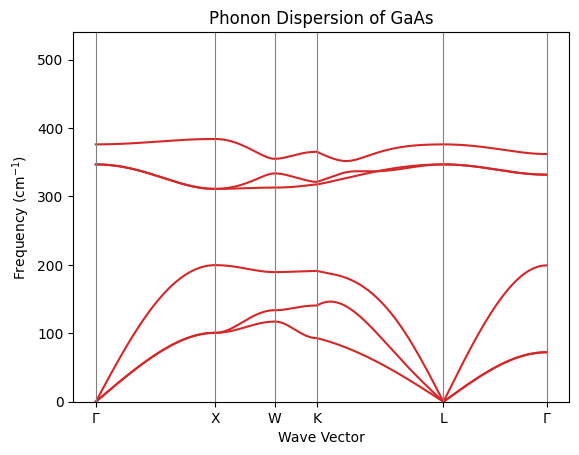

In [331]:
# Plot the phonon dispersion
with open('alas_bands.dat', 'r') as f:
    content = f.read()

blocks = content.strip().split('\n\n')

for block in blocks:
    data = np.loadtxt(block.strip().split('\n'))
    x = data[:, 0]
    y = data[:, 1]
    plt.plot(x, y, lw=1.5, c='C3')

high_symmetry_points = [0.0000, 0.7085, 1.0627, 1.3132, 2.6782, 2.0646]

plt.ylim([0,540])
plt.vlines(high_symmetry_points, *plt.ylim(), colors='gray', linestyles='-', linewidth=.8)
plt.xticks(
    high_symmetry_points, # you can find in the file `plot_si.out`
    ['$\Gamma$', 'X', 'W', 'K', '$\Gamma$', 'L']
) 
plt.xlabel('Wave Vector')
plt.ylabel('Frequency ($\mathrm{cm}^{-1}$)')
plt.title('Phonon Dispersion of GaAs')
plt.show()